In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pickle

import sys
from os.path import isfile, join
sys.path.insert(0, join(os.getcwd(),os.pardir))

from recipe_gen.pairing_utils import PairingData
from KitcheNette_master.unk_pairs_gen import getMainIngr

In [2]:
FOLDER_PATH = "F:\\user\\Google Drive\\Catherning Folder\\THU\\Thesis\\Work\\Recipe datasets"
DATASET = ["scirep-cuisines-detail","Yummly28"]
FILES = ["cleaned_data.pkl","full_data.pkl"]

known_path = os.path.join(os.getcwd(),os.pardir,"KitcheNette_master","data","kitchenette_pairing_scores.csv")
unk_path = os.path.join(os.getcwd(),os.pardir,"KitcheNette_master","results","prediction_unknowns_kitchenette_pretrained.mdl.csv")
pairing_pickle = os.path.join(os.getcwd(),os.pardir,"KitcheNette_master","results","full_pairings.pkl")

In [3]:
# FROM NN_classification
def createDFrame(file):
    
    dataset = DATASET[1]
    df = pd.read_pickle(os.path.join(
        FOLDER_PATH, dataset, file))
    df = df.set_index("id")
    len1 = len(df)

    dataset = DATASET[0]
    df2 = pd.read_pickle(os.path.join(
        FOLDER_PATH, dataset, file))
    df2["id"] = [len(df)+i for i in range(len(df2))]
    df2 = df2.set_index("id")
    df = pd.concat([df, df2],sort=False)
    if len(df)!=len1+len(df2):
        print("Error! Missing data")

    return df

df_train = createDFrame(FILES[1])
df_train.columns

Index(['cuisine', 'ingredients', 'all_ingredients'], dtype='object')

In [4]:
df_train["nb_ingrs"]=[len(x) for x in df_train["ingredients"]]

In [5]:
pairing = PairingData([unk_path,known_path], pickle_file=pairing_pickle, min_score=-1,trim=False)

742 pairs in total
0 pair(s) not added because of an absent ingredient in the vocab or false ingredient
rice_chex corn_chex
malt_extract irish_mos
hop irish_mos
ogo ahi
piloncillo canela
borax clementine
candlenut galangal
glitter lemongras
khoya cardamom_powder
hing toor_dal
channa_dal toor_dal
malanga yucca_root
dragee edible_glitter
glace_cherry mixed_peel
shrimp_paste candlenut
capicola sopressatum
curry toor_dal
asafoetida_powder toor_dal
ajwain black_salt
pork_butt ti
khoya ghee
mixed_peel sultana
ajwain besan
hickory_chip charcoal
french_bean ajinomoto
herbsaint rye_whiskey
ground_coriander ground_cumin
pig charcoal
mixed_spice mixed_peel
khoya saffron_strand
mixed_peel currant
kasuri_methi garam_masala_powder
gochujang dashida
mortadella sopressatum
chia_seed maca
garam_masala_powder methi
ajwain chat_masala
kitchen_twine cheesecloth
ajinomoto soya_sauce
herbsaint bitter
okra file_powder
masala toor_dal
konbu bonito_flake
kasuri_methi red_chili_powder
candied_peel currant
matzo

dry_white_wine turbot
curry_powder raitum
blue_food_coloring cooky
peanut_oil gai_lan
ajinomoto green_chily
fresh_parsley mirliton
caper caponatum
rosemary cavolo_nero
pak_choi chili_sauce
cooky orange_gelatin
dried_thyme tasso
fish_fumet white_wine
file_powder smoked_ham
pak_choi red_pepper
cooky coffee_ice_cream
curry_powder satay_sauce
gumdrop cooky
spinach cannelloni
angel_hair_pasta tasso
sweet_chili_sauce red_curry_paste
leek dashida
yellow_onion tasso
warm_water hot_roll_mix
pappadam turmeric
crabmeat file_powder
golden_raisin panettone
beer knockwurst
sausage gumbo_file
buttermilk rennet
green file_powder
cassium ground_coriander
green_food_coloring cooky
chicken_stock squab
molass porter
shrimp tasso
dragee chocolate
ajinomoto cabbage
turkey charcoal
remoulade_sauce fresh_parsley
banana bee_pollen
caster_sugar mixed_peel
celery_rib file_powder
green_pepper conch
cilantro nopale
cooky candy
pak_choi fish_sauce
barbecue_sauce charcoal
broccoli cavatelli
cooky cake
kielbasa file_

scallion choy_sum
chicken_broth cornstarch_paste
parmesan_rind chicken_stock
bottarga fresh_lemon_juice
crispy_rice_cereal cooky
remoulade_sauce dried_thyme
ground_nutmeg crumb_topping
parmesan_rind parmesan_cheese
ginger toor_dal
perciatelli crushed_red_pepper_flake
oil methi
oil sev
diced_onion file_powder
kitchen_twine fresh_thyme
kitchen_twine ground_pork
ginger butterfish
ginger choy_sum
conch red_bell_pepper
fresh_lemon_juice purslane
paprika mirliton
cooky romaine_lettuce
vinegar knockwurst
cooky green_grape
red_wine_vinegar crayfish
thyme file_powder
mixed_peel orange
mushroom sauterne
jackfruit banana
ginger pak_choi
ginger dashida
heavy_cream tasso
cooky condensed_milk
file_powder dried_basil
chicken file_powder
paprika tasso
tripe ham
ganache light_corn_syrup
lemon caperberry
fresh_cilantro culantro
confectioner's_sugar fondant
bay knockwurst
chive tasso
dry_white_wine crayfish
soy_sauce choy_sum
fresh_parsley tasso
file_powder sausage
milk_chocolate cooky
cilantro pappadam


tabasco_sauce tasso
cream_tartar sweetened_flaked_coconut
dragee heavy_cream
garlic_powder gumbo_file
walnut candied_peel
potato lovage
remoulade_sauce tomato
carrot bisto
sopressatum fresh_ground_black_pepper
kitchen_twine bacon
yellow_cake_mix cooky
creme_anglaise granulated_sugar
onion gumbo_file
kitchen_twine white_wine
dragee confectioner's_sugar
ganache baking_powder
cilantro rom
nutmeg creme_anglaise
perciatelli olive_oil
salsify heavy_cream
garlic_clove tlefish
teff baking_soda
ground_ginger mixed_peel
remoulade_sauce garlic
lemon gremolatum
cream_cheese cooky
scone heavy_cream
poultry celery
bottarga olive_oil
jicama ground_cumin
ganache dark_brown_sugar
kitchen_twine chicken_stock
cold_water charcoal
baharat tomato
broth couscous
tripe onion
wheatberry honey
dry_oregano feta_cheese
remoulade_sauce lemon
cooky instant_coffee_granule
carrot caciocavallo
teff water
pak_choi chicken_stock
perciatelli parmesan_cheese
onion_seed tomato
white_baking baking_powder
teff baking_powder


pigeon onion
cornstarch pak_choi
verju fresh_ground_black_pepper
capon fresh_ground_black_pepper
fresh_lemon_juice berbere
carrot fideo
basil file_powder
kitchen_twine red_pepper_flake
tabasco_sauce beefsteak_tomato
cooked_brown_rice miso
olivada olive_oil
yellow_bell_pepper minced_ginger
cannelloni salt_pepper
egg white_baking
file_powder red_pepper_flake
file_powder yellow_onion
chimichurri_sauce garlic
sugar cornstarch_paste
bisto onion
onion_seed onion
tomato_jam olive_oil
black_pepper beef_brisket
sugar double_crust
olive_oil recaito
culantro vegetable_oil
chicken_broth parmesan_rind
tomato_paste tasso
worcestershire_sauce conch
kitchen_twine garlic
olive_oil rom
kitchen_twine red_onion
baby_bok_choy broccoli_floret
creme_anglaise milk
lemon_juice squab
vanilla_extract fondant
tripe potato
cooky banana
pigeon salt_pepper
cooky vanilla_extract
chicken_broth duckling
barberry vegetable_oil
almond_extract cooky
carrot saltpeter
garlic_paste eggplant
tomato file_powder
flour candied_p

kitchen_twine salt_pepper
egg_white cooky
black_pepper rom
cooky boiling_water
shichimi_togarashi water
cool_whip_topping candied_lemon_peel
olive_oil gravlax
egg ajinomoto
panch_phoron water
pike water
pure_vanilla_extract soy_sauce
cooky almond
satay_sauce vegetable_oil
tomato_sauce file_powder
charcoal vegetable_oil
tripe flour
purslane salt_pepper
lemon_peel apricot_jam
coconut_milk apricot_jam
blueberry pineapple
kudzu water
ajinomoto onion
black_pepper lovage
posole water
sugar panch_phoron
pappadam onion
kasuri_methi onion
raspberry_couli water
onion_soup onion
spelt water
garlic_clove lovage
cornstarch_paste salt
cavolo_nero onion
sweet_corn flour_tortilla
cooky graham_cracker_crumb
plum_tomato italian_cheese_blend
garlic_clove cannelloni
maple_syrup skim_milk
candlenut salt
cooky cake_flour
olive_oil quahog
water crayfish
cooky unsalted_butter
gumbo_file fresh_ground_black_pepper
sweetbread salt
soup_mix salt_pepper
condensed_milk boiling_water
egg malteser
egg caciocavallo
ce

fresh_parsley crabmeat
butter fondant
conch olive_oil
vin_santo flour
squab salt
capon butter
chinese_five_spice_powder salt_black_pepper
fresh_basil granulated_garlic
salt achiote_oil
salt verjuice
cooky pecan
water schmaltz
egg nopale
olive_oil culantro
light_soy_sauce apple_cider_vinegar
lemon_juice lemon_juice
broccoli chili_paste
poultry flour
salsify salt
mixed_peel salt
spelt salt
fine_sea_salt balsamic_vinegar
mirepoix salt
pie_plate salt
farmer_cheese granulated_sugar
tripe olive_oil
garlic_clove tasso
egg mirliton
double_crust egg
blueberry cooky
rockfish salt
ajwain onion
sugar hot_roll_mix
nopale water
cavolo_nero water
walnut fresh_parsley
white_wine_vinegar barley
liquid_honey salt
butterfish salt
sugar porter
cooking_oil smy_cream
apple rabbit
dashida onion
egg cardoon
ganache salt
sugar kamaboko
baking_soda cream_mushroom_soup
chervil vegetable_oil
double_crust water
sweetbread water
brown_sugar lovage
iceberg_lettuce fresh_basil
walleye salt
canela salt
remoulade_sauce

In [6]:
len(pairing)

823

In [7]:
VOCAB_PATH = os.path.join(os.getcwd(),os.pardir,"recipe_1m_analysis", "data") 
with open(os.path.join(VOCAB_PATH, "recipe1m_vocab_ingrs.pkl"), 'rb') as f:
        vocab_ingrs = pickle.load(f)
        
vocab_main_ingr = getMainIngr(vocab_ingrs)
print(len(vocab_main_ingr),len(vocab_ingrs))


996 1000


In [8]:
vocab_ingrs.delete_word("tawny_port")

In [9]:
vocab_main_ingr.word2idx["tawny_port"]

803

In [10]:
"tawny_port" in pairing.pairedIngr

False

In [27]:
to_add = []
count_err = 0
for index, recipe in df_train.iterrows():
    score = 0
    nb=0
    for i,ingr1 in enumerate(recipe["ingredients"]):
        for ingr2 in recipe["ingredients"][i+1:]:
            try:
                score += pairing.pairing_scores[pairing.pairedIngr[ingr1]][pairing.pairedIngr[ingr2]]
                nb+=1
                
            except KeyError:
                pass
                #if ingr1 in vocab_ingrs.word2idx and ingr2 in vocab_ingrs.word2idx:
                 #   try:
                  #      ing1 = vocab_main_ingr.idx2word[vocab_ingrs.word2idx[ingr1]][0]
                   #     ing2 = vocab_main_ingr.idx2word[vocab_ingrs.word2idx[ingr2]][0]
                    #    score += pairing.pairing_scores[pairing.pairedIngr[ing1]][pairing.pairedIngr[ing2]]
                     #   nb+=1
                    #except KeyError:
                     #   count_err+=1
    try:
        to_add.append(score/nb)
    except ZeroDivisionError:
        to_add.append(0)
        
df_train["recipe_score"] = to_add
print(count_err)

0


In [29]:
df_train["recipe_score"].mean()  

-0.10827833605368169

In [30]:
df_train[["cuisine","recipe_score"]][df_train["recipe_score"]!=0].groupby(["cuisine"]).mean().sort_values(by="recipe_score")

,recipe_score
cuisine,
SouthernEuropean,-0.131041
WesternEuropean,-0.119068
Asian,-0.115664
LatinAmerican,-0.114791
NorthAmerican,-0.114402
EasternEuropean,-0.111678
SoutheastAsian,-0.108852
NorthernEuropean,-0.101696
MiddleEastern,-0.096388


Text(0, 0.5, 'Proportion of the cuisine(%)')

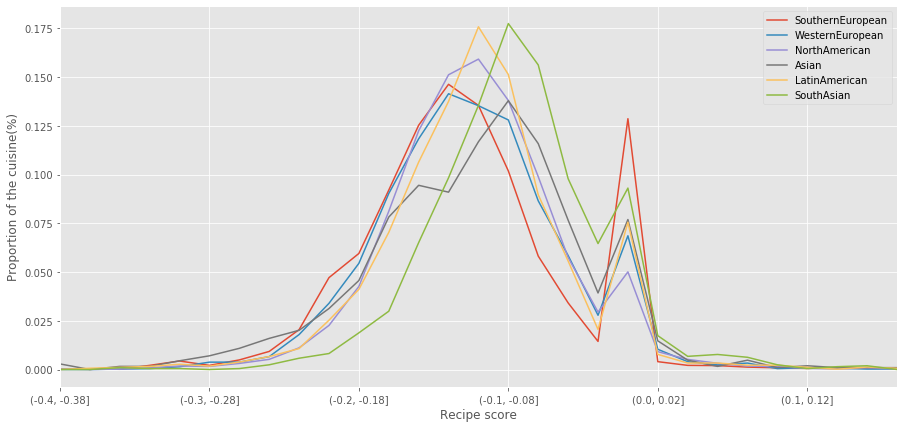

In [31]:
%matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(15,7))

nb_bins = 30
leg = []
for cuis in df_train.cuisine.unique()[:6]:
#cuis = "Asian"

    df = df_train[df_train["cuisine"]==cuis]
    bins = pd.cut(df['recipe_score'], [-0.4+x * 0.6/nb_bins for x in range(0, nb_bins)])
    data = df.groupby(bins).agg(['count'])[["recipe_score"]]
    data = data/data.sum()
    data.columns = data.columns.droplevel()
    data.plot(y="count",ax=ax)#,xticks=[-1+x * 2/nb_bins for x in range(0, nb_bins)]);
    leg.append(cuis)
    
ax.legend(leg)
ax.set_xlabel("Recipe score")
ax.set_ylabel("Proportion of the cuisine(%)")

In [ ]:
%matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(15,7))

nb_bins = 30
leg = []
for cuis in df_train.cuisine.unique()[6:]:
#cuis = "Asian"

    df = df_train[df_train["cuisine"]==cuis]
    bins = pd.cut(df['recipe_score'], [-0.4+x * 0.6/nb_bins for x in range(0, nb_bins)])
    data = df.groupby(bins).agg(['count'])[["recipe_score"]]
    data = data/data.sum()
    data.columns = data.columns.droplevel()
    data.plot(y="count",ax=ax)#,xticks=[-1+x * 2/nb_bins for x in range(0, nb_bins)]);
    leg.append(cuis)
    
ax.legend(leg)
ax.set_xlabel("Recipe score")
ax.set_ylabel("Proportion of the cuisine(%)")

In [ ]:
df_train[(df_train["recipe_score"]==0) & (df_train["nb_ingrs"]>1)].groupby(["cuisine"]).count()

In [ ]:
len(df_train)